# Model Time Series ML to predict metro frequentation during JO period with jo or not of stations rattached to a site with known past events

In [52]:
# Dans ce notebook, on explore les données et on crée un premier modele de ML (fbProphet), sur les sites pour lequels on connait la fréquentation d'évènements passées.
# Les stations de métro concernées sont indiquées dans la liste stations_totales 2 cellules en dessous.
# Pour utiliser ce notebook, il suffit de mettre la station voulue, et exécuter tout le notebook.

In [53]:
station = "STADE DE FRANCE-SAINT-DENIS"   # mettre la station voulue, et exécuter tout le notebook.

In [54]:
stations_totales = ["PORTE DE SAINT-CLOUD", "PORTE D'AUTEUIL", "BOULEVARD VICTOR", "STADE DE FRANCE-SAINT-DENIS", "LA PLAINE-STADE DE FRANCE", "SAINT-DENIS-PORTE DE PARIS"]
stations_RG = ["PORTE DE SAINT-CLOUD", "PORTE D'AUTEUIL"]
stations_PDP = ["PORTE DE SAINT-CLOUD", "PORTE D'AUTEUIL", "BOULEVARD VICTOR"]
stations_SDF = ["STADE DE FRANCE-SAINT-DENIS", "LA PLAINE-STADE DE FRANCE", "SAINT-DENIS-PORTE DE PARIS"]

In [55]:
#import librairies
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math
from prophet.utilities import regressor_coefficients



In [56]:
#read all CSV
data = pd.read_csv("99-Data_Clean/data_concatenaited.csv")
data.head()

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_61394/2921695896.py:2: DtypeWarning:

Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.



,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,lda
0,01/01/2015,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,117,NaN
1,01/01/2015,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,37,NaN
2,01/01/2015,100,110,1,PORTE MAILLOT,71379,FGT,172,NaN
3,01/01/2015,100,110,1,PORTE MAILLOT,71379,IMAGINE R,605,NaN
4,01/01/2015,100,110,1,PORTE MAILLOT,71379,NAVIGO,2039,NaN


In [57]:
#Extract only informations about the two stations
mask = (data['LIBELLE_ARRET'] == station)
data = data.loc[mask]
data.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,lda
2392,01/01/2015,800,804,806,STADE DE FRANCE-SAINT-DENIS,72206,AMETHYSTE,9,NaN
2393,01/01/2015,800,804,806,STADE DE FRANCE-SAINT-DENIS,72206,AUTRE TITRE,25,NaN
2394,01/01/2015,800,804,806,STADE DE FRANCE-SAINT-DENIS,72206,FGT,27,NaN
2395,01/01/2015,800,804,806,STADE DE FRANCE-SAINT-DENIS,72206,IMAGINE R,45,NaN
2396,01/01/2015,800,804,806,STADE DE FRANCE-SAINT-DENIS,72206,NAVIGO,142,NaN


In [58]:
#Convert JOUR to datetime
data['JOUR'] = data['JOUR'].apply(lambda x: pd.to_datetime(x))

#Sort Values
data = data.sort_values(by='JOUR', ascending=True)

#Replace Moins de 5 par 5 dans NB_VALD
data['NB_VALD'] = data['NB_VALD'].apply(lambda x: 5 if x == 'Moins de 5' else x)

#Convert NB_VALD to integer
data['NB_VALD'] = data['NB_VALD'].apply(lambda x: int(x))

mask_years=(data['JOUR'].dt.year<2020)
data=data.loc[mask_years]

#Delete unuseful columns
data = data[['JOUR','NB_VALD']]

#GroupBy JOUR
data = data.groupby(['JOUR']).sum()
data = data.reset_index()

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_61394/1211621673.py:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [59]:
data.describe(include='all')

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_61394/1336221646.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,JOUR,NB_VALD
count,1826,1826.000000
unique,1826,NaN
top,2015-01-01 00:00:00,NaN
freq,1,NaN
first,2015-01-01 00:00:00,NaN
last,2019-12-31 00:00:00,NaN
mean,NaN,9865.309419
std,NaN,6513.920484
min,NaN,7.000000
25%,NaN,1655.000000


In [60]:
#Distribution
fig=px.line(data,x="JOUR",y='NB_VALD')#,color="LIBELLE_ARRET")
fig.show()

In [61]:
mean_data = data['NB_VALD'].mean()
std_data = data['NB_VALD'].std()
min_data = mean_data - (std_data * (1.5))
max_data = mean_data + (std_data * (1.5))
print(min_data)
print(max_data)
print(len(data.loc[data['NB_VALD'] < min_data]))
print(len(data.loc[data['NB_VALD'] > max_data]))

94.42869330647954
19636.190145685854
36
6


In [62]:
# change outlier
data['NB_VALD'] = [data['NB_VALD'][i] if (data['NB_VALD'][i] >= min_data)
                    else data['NB_VALD'][i-7] if ((data['NB_VALD'][i] < min_data) and (i > 6) and (data['NB_VALD'][i-7] > min_data))
                    else data['NB_VALD'][i-14] if ((data['NB_VALD'][i] < min_data) and (i > 13) and (data['NB_VALD'][i-7] < min_data) and (data['NB_VALD'][i-14] > min_data))
                    else data['NB_VALD'][i-21] if ((data['NB_VALD'][i] < min_data) and (i > 20) and (data['NB_VALD'][i-7] < min_data) and (data['NB_VALD'][i-14] < min_data) and (data['NB_VALD'][i-21] > min_data))
                    else (int(min_data) + 1)
                    for i in range(len(data['NB_VALD']))]
#data['NB_VALD'] = np.where(data['NB_VALD'] < min_data, data['NB_VALD'].shift(7), data['NB_VALD'])

In [63]:
data['NB_VALD'].loc[data['NB_VALD'] <= min_data+1]

Series([], Name: NB_VALD, dtype: int64)

In [64]:
#Distribution
fig=px.line(data,x="JOUR",y='NB_VALD')#,color="LIBELLE_ARRET")
fig.show()

In [65]:
df_pdp = pd.read_csv("99-Data_Clean/df_pdp.csv")
df_pdp['datestamp'] = df_pdp['datestamp'].apply(lambda x: pd.to_datetime(x))
df_pdp.head()

,date,place,affluence,datestamp
0,So. 18.01.15,D,45561,2015-01-18
1,Mi. 21.01.15,D,40000,2015-01-21
2,Fr. 30.01.15,D,44955,2015-01-30
3,Mi. 11.02.15,D,35000,2015-02-11
4,Sa. 14.02.15,D,45571,2015-02-14


In [66]:
df_sdf = pd.read_csv("99-Data_Clean/df_sdf.csv")
df_sdf['datestamp'] = df_sdf['datestamp'].apply(lambda x: pd.to_datetime(x))
df_sdf.head()

,event_name,date,event_description,datestamp
0,La Voie Royale de Saint-Denis 2023,Dimanche 05 novembre 2023,NaN,2023-11-05
1,FRANCE vs AUSTRALIE 2023,Dimanche 27 août 2023,Match de préparation à la Coupe du Monde,2023-08-27
2,THE WEEKND 2 2023,Dimanche 30 juillet 2023,After Hours til Dawn,2023-07-30
3,THE WEEKND 2023,Samedi 29 juillet 2023,After Hours til Dawn,2023-07-29
4,Rammstein,Samedi 22 juillet 2023,NaN,2023-07-22


In [67]:
df_rg = pd.read_csv("99-Data_Clean/df_rg.csv")
df_rg['datestamp'] = df_rg['JOUR'].apply(lambda x: pd.to_datetime(x))
df_rg.head()

,JOUR,affluence,datestamp
0,2015-05-24,30522,2015-05-24
1,2015-05-25,34936,2015-05-25
2,2015-05-26,33732,2015-05-26
3,2015-05-27,34793,2015-05-27
4,2015-05-28,34915,2015-05-28


In [68]:
#Add a column Event to specify if it's an event day (based on Rolland Garros, Parc des Princes, and Stade de France dates)

def event_pdp(x):
    if x in list(df_pdp['datestamp']):
        for i in range(len(df_pdp['datestamp'])):
            if df_pdp['datestamp'][i] == x:
                return math.log(df_pdp['affluence'][i])
    else:
        return 0

def event_sdf(x):
    if x in list(df_sdf['datestamp']):
        return math.log(80698)
    else:
        return 0


def event_rg(x):
    if x in list(df_rg['datestamp']):
        for i in range(len(df_rg['datestamp'])):
            if df_rg['datestamp'][i] == x:
                return math.log(df_rg['affluence'][i])
    else:
        return 0

data['EVENT_RG_LOG'] = data['JOUR'].apply(lambda x: event_rg(x) if station in stations_RG else 0)
data['EVENT_PDP_LOG'] = data['JOUR'].apply(lambda x: event_pdp(x) if station in stations_PDP else 0)
data['EVENT_SDF_LOG'] = data['JOUR'].apply(lambda x: event_sdf(x) if station in stations_SDF else 0)


In [69]:
#Add a column Event to specify if it's an event day (based on Rolland Garros, Parc des Princes, and Stade de France dates)

def event_pdp(x):
    if x in list(df_pdp['datestamp']):
        return 1
    else:
        return 0

def event_sdf(x):
    if x in list(df_sdf['datestamp']):
        return 1
    else:
        return 0


def event_rg(x):
    if x in list(df_rg['datestamp']):
        return 1
    else:
        return 0

data['EVENT_RG'] = data['JOUR'].apply(lambda x: event_rg(x) if station in stations_RG else 0)
data['EVENT_PDP'] = data['JOUR'].apply(lambda x: event_pdp(x) if station in stations_PDP else 0)
data['EVENT_SDF'] = data['JOUR'].apply(lambda x: event_sdf(x) if station in stations_SDF else 0)

In [70]:
data.head()

,JOUR,NB_VALD,EVENT_RG_LOG,EVENT_PDP_LOG,EVENT_SDF_LOG,EVENT_RG,EVENT_PDP,EVENT_SDF
0,2015-01-01,304,0,0,0.0,0,0,0
1,2015-01-02,699,0,0,0.0,0,0,0
2,2015-01-03,682,0,0,0.0,0,0,0
3,2015-01-04,13566,0,0,0.0,0,0,0
4,2015-01-05,571,0,0,0.0,0,0,0


SOME DATA VIS

In [71]:
#Statistics
data.describe(include="all")

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_61394/3692600302.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,JOUR,NB_VALD,EVENT_RG_LOG,EVENT_PDP_LOG,EVENT_SDF_LOG,EVENT_RG,EVENT_PDP,EVENT_SDF
count,1826,1826.000000,1826.0,1826.0,1826.000000,1826.0,1826.0,1826.000000
unique,1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,10031.979737,0.0,0.0,0.532129,0.0,0.0,0.047097
std,NaN,6424.623574,0.0,0.0,2.394207,0.0,0.0,0.211905
min,NaN,105.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
25%,NaN,1769.750000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [72]:
#Distribution
fig=px.histogram(data,x="NB_VALD")
fig.show()

In [73]:
#Distribution
fig=px.line(data,x="JOUR",y=('NB_VALD'))
fig.show()

In [74]:
##Check if all data is available

start_date = data['JOUR'].min()
end_date = data['JOUR'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Verify missing values
missing_dates = all_dates[~all_dates.isin(data['JOUR'])]

if len(missing_dates) == 0:
    print("Tous les jours sont présents dans le jeu de données.")
else:
    print("Il manque des jours dans le jeu de données.")
    print("Dates manquantes :", missing_dates)

Tous les jours sont présents dans le jeu de données.


In [75]:
len(missing_dates)

0

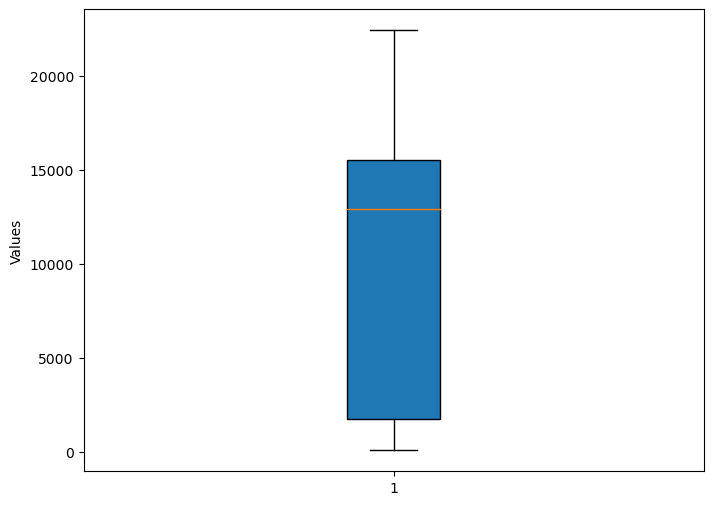

In [76]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['NB_VALD'],patch_artist=True)  # 'patch_artist=True' for filling the box

plt.ylabel('Values')
plt.show()

In [77]:
data.head()

,JOUR,NB_VALD,EVENT_RG_LOG,EVENT_PDP_LOG,EVENT_SDF_LOG,EVENT_RG,EVENT_PDP,EVENT_SDF
0,2015-01-01,304,0,0,0.0,0,0,0
1,2015-01-02,699,0,0,0.0,0,0,0
2,2015-01-03,682,0,0,0.0,0,0,0
3,2015-01-04,13566,0,0,0.0,0,0,0
4,2015-01-05,571,0,0,0.0,0,0,0


In [78]:
data['NB_VALD'] = np.log(data['NB_VALD'])

In [79]:
split_date='2019-01-01'
data_train = data.loc[data['JOUR'] < split_date].copy()
data_test = data.loc[data['JOUR'] >= split_date].copy()

In [80]:
# Format data for prophet model using ds and y
data_train_prophet = data_train.rename(columns={'JOUR':'ds','NB_VALD':'y'})
data_train_prophet.head()

,ds,y,EVENT_RG_LOG,EVENT_PDP_LOG,EVENT_SDF_LOG,EVENT_RG,EVENT_PDP,EVENT_SDF
0,2015-01-01,5.717028,0,0,0.0,0,0,0
1,2015-01-02,6.549651,0,0,0.0,0,0,0
2,2015-01-03,6.525030,0,0,0.0,0,0,0
3,2015-01-04,9.515322,0,0,0.0,0,0,0
4,2015-01-05,6.347389,0,0,0.0,0,0,0


In [81]:
# Setup and train model and fit
model = Prophet(yearly_seasonality=True, weekly_seasonality=True,changepoint_prior_scale=0.5)
model.add_regressor('EVENT_RG')
model.add_regressor('EVENT_PDP')
model.add_regressor('EVENT_SDF')
model.add_regressor('EVENT_RG_LOG')
model.add_regressor('EVENT_PDP_LOG')
model.add_regressor('EVENT_SDF_LOG')
model.add_country_holidays(country_name='FR')
model.fit(data_train_prophet)

12:06:11 - cmdstanpy - INFO - Chain [1] start processing
12:06:11 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
# Predict on training set with model
data_test_prophet = data_test.rename(columns={'JOUR':'ds'})
data_test_fcst = model.predict(df=data_test_prophet)

In [83]:
data_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,8.820866,5.097418,7.634470,8.820866,8.820866,0.0,0.0,0.0,0.0,...,0.428742,0.428742,0.428742,-0.405151,-0.405151,-0.405151,0.0,0.0,0.0,6.351185
1,2019-01-02,8.820839,7.598968,10.126991,8.820839,8.820839,0.0,0.0,0.0,0.0,...,0.453835,0.453835,0.453835,-0.405622,-0.405622,-0.405622,0.0,0.0,0.0,8.858224
2,2019-01-03,8.820812,7.694079,10.056972,8.820812,8.820812,0.0,0.0,0.0,0.0,...,0.466627,0.466627,0.466627,-0.401915,-0.401915,-0.401915,0.0,0.0,0.0,8.874696
3,2019-01-04,8.820785,7.530309,10.043175,8.820785,8.820785,0.0,0.0,0.0,0.0,...,0.387699,0.387699,0.387699,-0.394052,-0.394052,-0.394052,0.0,0.0,0.0,8.803603
4,2019-01-05,8.820758,6.169367,8.756808,8.820758,8.820758,0.0,0.0,0.0,0.0,...,-1.004223,-1.004223,-1.004223,-0.382133,-0.382133,-0.382133,0.0,0.0,0.0,7.423573


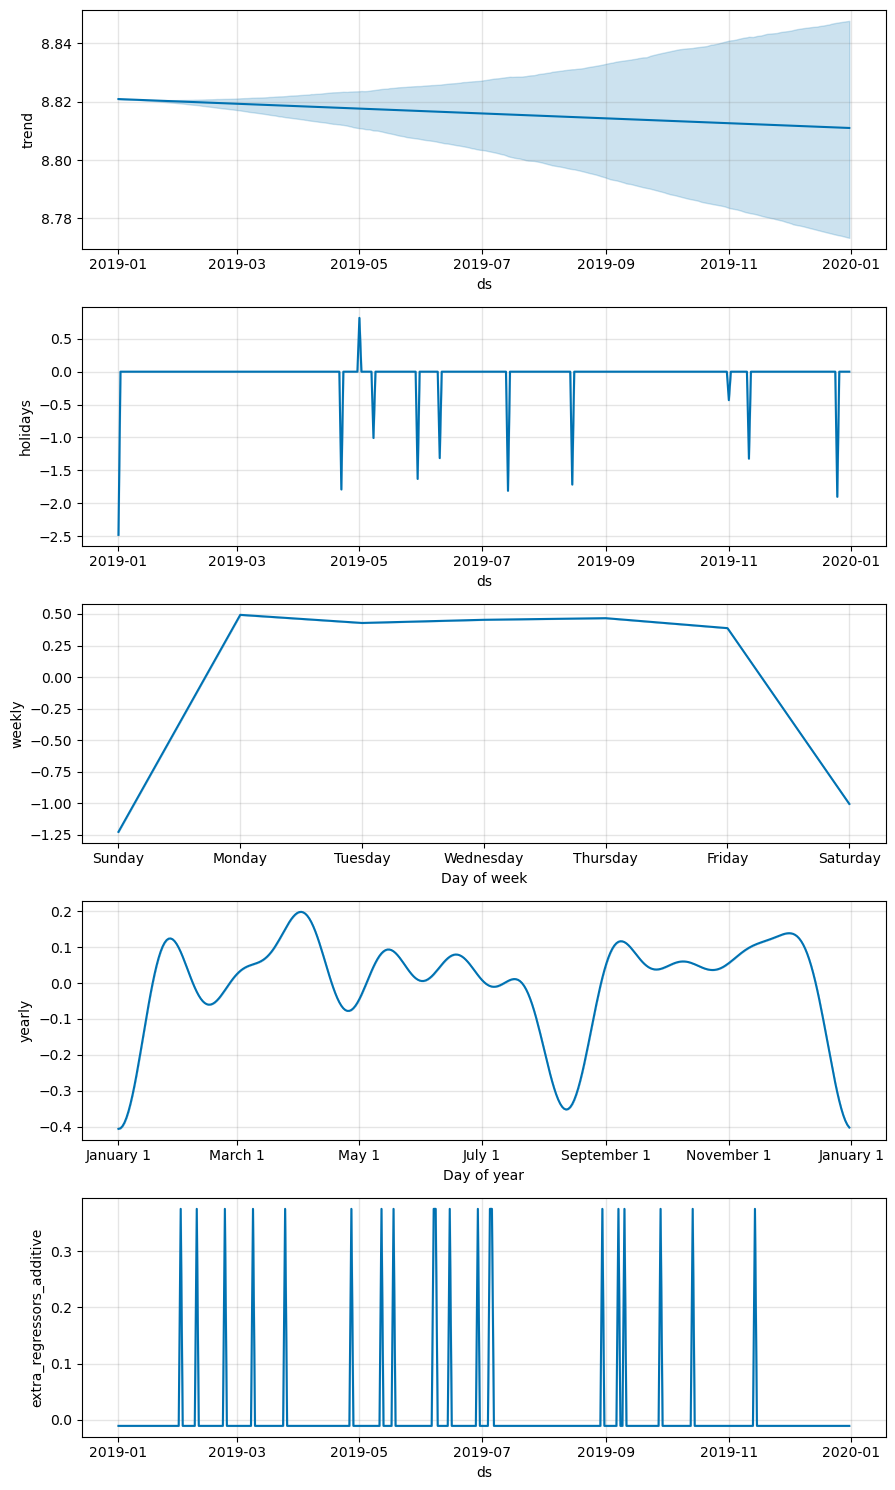

In [84]:
# Plot the components of the model
fig = model.plot_components(data_test_fcst)

In [85]:
fig = px.line(x = data_test['JOUR'], y = data_test['NB_VALD'])
fig.add_trace(px.line(data_test_fcst, x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

In [86]:
mse = mean_squared_error(y_true=data_test['NB_VALD'],
                        y_pred=data_test_fcst['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 0.8456039188674411


In [87]:
mae = mean_absolute_error(y_true=data_test['NB_VALD'],
                   y_pred=data_test_fcst['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 0.6448437375333235


In [88]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

mape = mean_absolute_percentage_error(y_true=data_test['NB_VALD'],
                    y_pred=data_test_fcst['yhat'])


print(f"La MAPE est : {mape:.2f}%")


La MAPE est : 7.72%


In [92]:
df_jo=pd.read_csv("99-Data_Clean/event_jo.csv")
df_jo = df_jo[['ds','EVENT_PDP','EVENT_RG','EVENT_SDF']]
df_jo.head()

,ds,EVENT_PDP,EVENT_RG,EVENT_SDF
0,2024-07-01,0,0,0
1,2024-07-02,0,0,0
2,2024-07-03,0,0,0
3,2024-07-04,0,0,0
4,2024-07-05,0,0,0


In [95]:
# log of stadium capacity
df_jo['EVENT_PDP_LOG']=df_jo['EVENT_PDP'].apply(lambda x:np.log(47926) if ((x==1) & (station in stations_PDP)) else 0)
df_jo['EVENT_RG_LOG']=df_jo['EVENT_RG'].apply(lambda x:np.log(34000) if ((x==1) & (station in stations_RG)) else 0)
df_jo['EVENT_SDF_LOG']=df_jo['EVENT_SDF'].apply(lambda x:np.log(77083) if ((x==1) & (station in stations_SDF)) else 0)

In [96]:
df_jo.head(30)

,ds,EVENT_PDP,EVENT_RG,EVENT_SDF,EVENT_PDP_LOG,EVENT_RG_LOG,EVENT_SDF_LOG
0,2024-07-01,0,0,0,0,0,0.000000
1,2024-07-02,0,0,0,0,0,0.000000
2,2024-07-03,0,0,0,0,0,0.000000
3,2024-07-04,0,0,0,0,0,0.000000
4,2024-07-05,0,0,0,0,0,0.000000
5,2024-07-06,0,0,0,0,0,0.000000
6,2024-07-07,0,0,0,0,0,0.000000
7,2024-07-08,0,0,0,0,0,0.000000
8,2024-07-09,0,0,0,0,0,0.000000
9,2024-07-10,0,0,0,0,0,0.000000


In [97]:
forecast = model.predict(df_jo)

In [98]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-01,8.766272,8.057648,10.436612,8.766272,8.766272,0.0,0.0,0.0,0.0,...,0.492938,0.492938,0.492938,0.007414,0.007414,0.007414,0.0,0.0,0.0,9.255796
1,2024-07-02,8.766245,8.025388,10.535103,8.766245,8.766245,0.0,0.0,0.0,0.0,...,0.428742,0.428742,0.428742,0.001910,0.001910,0.001910,0.0,0.0,0.0,9.186069
2,2024-07-03,8.766218,7.886423,10.397967,8.766218,8.766218,0.0,0.0,0.0,0.0,...,0.453835,0.453835,0.453835,-0.002669,-0.002669,-0.002669,0.0,0.0,0.0,9.206556
3,2024-07-04,8.766190,7.961885,10.505515,8.766190,8.766190,0.0,0.0,0.0,0.0,...,0.466627,0.466627,0.466627,-0.006222,-0.006222,-0.006222,0.0,0.0,0.0,9.215767
4,2024-07-05,8.766163,7.828598,10.298103,8.766163,8.766163,0.0,0.0,0.0,0.0,...,0.387699,0.387699,0.387699,-0.008691,-0.008691,-0.008691,0.0,0.0,0.0,9.134343


In [99]:
fig = px.line(x = forecast['ds'], y = np.exp(forecast['yhat']))

fig.show()

In [100]:
forecast=forecast[['ds', 'yhat']]
forecast['station']=station
forecast.to_csv(f"98-Forecast/forecast_jo_{station}.csv", index=False)

In [101]:
df_ssjo=df_jo

In [102]:
df_ssjo['EVENT_PDP']=0
df_ssjo['EVENT_RG']=0
df_ssjo['EVENT_SDF']=0
df_ssjo['EVENT_PDP_LOG']=0
df_ssjo['EVENT_RG_LOG']=0
df_ssjo['EVENT_SDF_LOG']=0

In [103]:
forecast_ssjo = model.predict(df_ssjo)

In [104]:
fig = px.line(x = forecast_ssjo['ds'], y = np.exp(forecast_ssjo['yhat']))

fig.show()

In [105]:
forecast_ssjo=forecast_ssjo[['ds', 'yhat']]
forecast_ssjo['station']=station
forecast_ssjo.to_csv(f"98-Forecast/forecast_ssjo_{station}.csv", index=False)

In [106]:
coefficients = regressor_coefficients(model)
coefficients.head(6)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,EVENT_RG,additive,0.000000,0.000000,0.000000,0.000000
1,EVENT_PDP,additive,0.000000,0.000000,0.000000,0.000000
2,EVENT_SDF,additive,0.000000,0.146281,0.146281,0.146281
3,EVENT_RG_LOG,additive,0.000000,0.000000,0.000000,0.000000
4,EVENT_PDP_LOG,additive,0.000000,0.000000,0.000000,0.000000
5,EVENT_SDF_LOG,additive,0.510403,0.021215,0.021215,0.021215


In [107]:
coefficients.to_csv(f"98-Forecast/coeff/coeff_{station}.csv", index=False)